In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
import torch.nn.functional as F 
from collections import deque # this python module implements exactly what we need for the replay memeory

In [2]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [3]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Replay memory

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Exploration policy

In [8]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [9]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out[0] / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

## Exploration profile

## Policy network

In [10]:
class ConvDQN(nn.Module):

    def __init__(self, channels, action_space_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=0),
            nn.ReLU()
        )

        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(200, 5, 2), 5, 2), 5, 2)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(160, 5, 2), 5, 2), 5, 2)
        linear_input_size = convw * convh * 32

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.linear(x)
        return x

## Update function

In [11]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    #states      = torch.tensor([s[0][0] for s in batch], dtype=torch.float32)
    states      = torch.stack([s[0][0] for s in batch])
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    #non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_next_states = torch.stack([s[2][0] for s in batch if s[2] is not None]) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [12]:
def ProcessScreen0(env):
    state_screen = env.render(mode='rgb_array')
    state_screen = state_screen[150:320, 150:450, 2]
    state_screen = state_screen.reshape((1, 85, 2, 150, 2)).max(4).max(2)
    state_screen = torch.tensor(state_screen.copy(), dtype=torch.float32)
    return state_screen

def ProcessScreen(env):
    screen = env.render(mode='rgb_array')
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    screen = np.dot(screen[..., :3], [0.2989, 0.5870, 0.1140])
    screen = screen[160:320, 200:400]
    #screen = screen.reshape((1, 80, 2, 100, 2)).max(4).max(2)
    screen = screen[np.newaxis, :]
    return torch.tensor(screen.copy(), dtype=torch.float32)

## Environment

In [13]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


torch.Size([1, 160, 200])


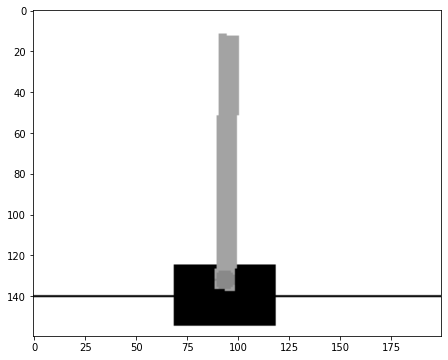

In [14]:
#Test image rescaling
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

state = env.reset()
state_screen = ProcessScreen(env)

env.close()

print(state_screen.size())

plt.figure(figsize=(12, 6))
plt.imshow(state_screen.cpu().squeeze().numpy(), cmap='gray')
plt.savefig('cartpole_gray.pdf', bbox_inches='tight')
plt.show()

## Initialization

In [15]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 0.05   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [16]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = ConvDQN(1, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = ConvDQN(1, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Training loop

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

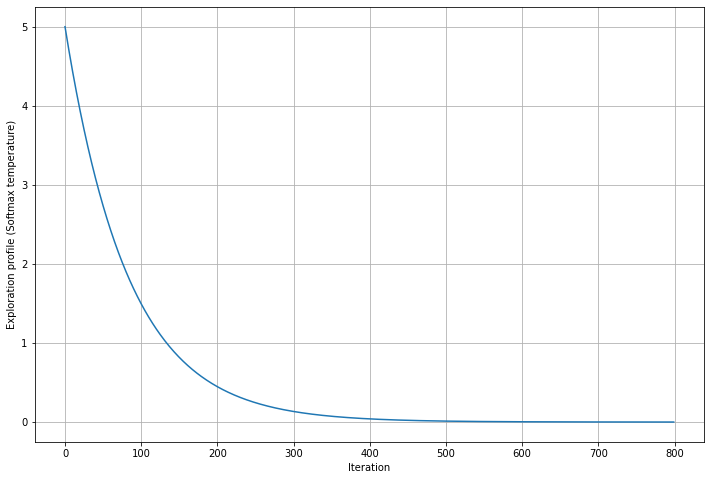

In [17]:
### Define exploration profile
initial_value = 5
num_iterations = 800
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [18]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

scores = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    state_img = ProcessScreen(env)
    state_img = state_img.unsqueeze(0)

    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state_img, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      next_state_img = ProcessScreen(env).unsqueeze(0)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None
          next_state_img = None 

      if type(next_state) != "NoneType":
          next_state_img = ProcessScreen(env).unsqueeze(0)

      # Update the replay memory
      replay_mem.push(state_img, action, next_state_img, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state
      state_img = next_state_img

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    scores.append(score)

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.940008876649582
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.880737540275333
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.822177354711398
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.764319787410582
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.707156408201104
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.650678888058284
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.594878997890946
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.539748607342402
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.485279683605809
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.431464290253745
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.378294586081827
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.325762823966207
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.273861349734766
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.222582601051861
EPISODE: 16 - FINAL SCOR

In [19]:
# Display the videos, not required outside Colab
#show_videos()

In [20]:
with open('pixels_scores.txt', 'w') as f:
    f.write(str(scores))

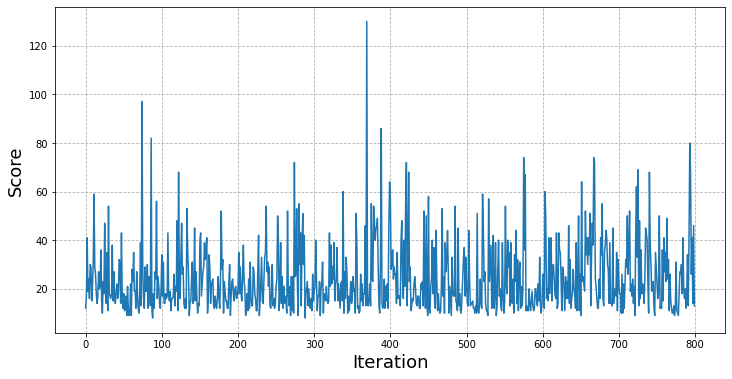

In [24]:
# Exploration profile
plt.figure(figsize=(12,6))
plt.plot(scores)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.grid(ls='--')
plt.savefig('pixel_scores.pdf')
plt.show()

## Final test

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    state_img = ProcessScreen(env).unsqueeze(0)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state_img, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      if type(next_state) != "NoneType":
          next_state_img = ProcessScreen(env).unsqueeze(0)
      # Set the current state for the next iteration
      state = next_state
      state_img = next_state_img
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

In [23]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.15618.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.15618.video000009.mp4
